## Testing
- have changed alot of definitions to be ED_... because I am altering them

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import sys 
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.pyplot as plt
import time as timer
start_all = timer.time()

In [ ]:
YR = 1994
dataf ="/Volumes/ESA_F4R/era/" 
#datao ="/Volumes/ESA_F4R/ed_prepare/" 
datao ="/Users/ellendyer/Desktop/"
datap ="/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/plots/era/"
datas ="/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/Shapefiles/"

In [ ]:
shp_cod = gpd.read_file(datas+"geoBoundaries-COD-ADM0.shp")
print(shp_cod)

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.OCEAN)
shp_cod.plot(ax=ax, edgecolor='pink',facecolor='none',lw=2,zorder=2,linestyle='-')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
plt.show()
plt.clf()

#### **Read in pre-processed files that have the following conversions:**

**Read in ERA5 data on pressure levels (hourly timesteps in fortnightly files)**
- *fortnightly files currently run from 1994-2024*
- resampled to monthly MS timestep
- shum multiplied by 1000 to convert from kg/kg --> g/kg
- pressure levels are divided by 100 to convert from Pa to hPa (only for fortnightly files)
- sort data by descending pressure levels (only for fortnightly files)


**Input file units:**
- plev - pa
- q - kg/kg
- u - m/s
- v - m/s

**Read in ERA5 land data (hourly in monthly files)**
- selecting hour 23 (0-23) of Prec and Evap because of how ERA5 Land variables are accumulated (https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790 - https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-accumulationsAccumulations)
- prec is multiplied by 1000 to convert from m to mm
- evap is multiplied by -1000 to convert from m to mm and upward fluxes in land model are considered negative
- Prec, Evap, and Psfc are then resampled to MS monthly and also interpolated to coarser pressure level grid

**Input file units:**
- tp - m
- e - m (-)
- sp - pa

**Merging all input datasets into one dataset for recyling code called ds**
- close both input datasets
- sort everything so latitude is south to north
- transpose dimensions so they run (lon,lat,level,time) as in recycling code
- save input ds to file

**Integrate zonal and meridional moisture flux**
- ***To do:*** do this with hourly data to test difference in rho
- **Must check if there are any nans in input arrays** - there can be none because we are using nans as an indicator in the modified definitions

Number of nans in Evap:  0
Number of nans in Prec:  0
Number of nans in Psfc:  0
Number of nans in Uwnd:  0
Number of nans in Vwnd:  0
Number of nans in Shum:  0
<xarray.DataArray 'Mask' (lat: 4, lon: 13)> Size: 416B
array([[2., 2., 2., 2., 1., 0., 0., 1., 2., 2., 2., 2., 2.],
       [2., 2., 1., 1., 1., 0., 0., 1., 2., 2., 2., 2., 2.],
       [2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.],
       [1., 1., 1., 1., 2., 2., 1., 1., 2., 2., 2., 2., 2.]])
Coordinates:
  * lon          (lon) float64 104B 28.0 28.25 28.5 28.75 ... 30.5 30.75 31.0
  * lat          (lat) float64 32B -13.0 -12.75 -12.5 -12.25
    spatial_ref  int64 8B 0


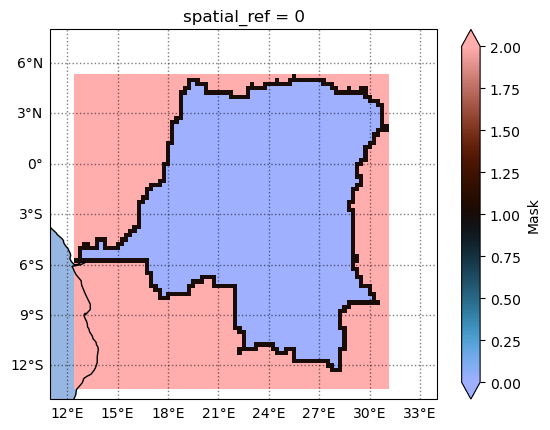

<Figure size 640x480 with 0 Axes>

In [ ]:
dsin = xr.open_dataset(datao+"full_reg_erads_"+str(YR)+".nc")

print('Number of nans in Evap: ', dsin['Evap'].where(np.isnan(dsin['Evap'])==True,drop=True).count().values)
print('Number of nans in Prec: ', dsin['Prec'].where(np.isnan(dsin['Prec'])==True,drop=True).count().values)
print('Number of nans in Psfc: ', dsin['Psfc'].where(np.isnan(dsin['Psfc'])==True,drop=True).count().values)
print('Number of nans in Uwnd: ', dsin['Uwnd'].where(np.isnan(dsin['Uwnd'])==True,drop=True).count().values)
print('Number of nans in Vwnd: ', dsin['Vwnd'].where(np.isnan(dsin['Vwnd'])==True,drop=True).count().values)
print('Number of nans in Shum: ', dsin['Shum'].where(np.isnan(dsin['Shum'])==True,drop=True).count().values)

dsin = dsin.transpose("time","level","lat","lon",missing_dims='ignore')
dsin = dsin.rio.set_spatial_dims(x_dim="lon",y_dim="lat")
dsin.rio.write_crs("epsg:4326", inplace=True)
ds = dsin.rio.clip(shp_cod.geometry.apply(mapping),shp_cod.crs)

ds['Mask']=xr.full_like(ds['Evap'][0,:,:],fill_value=0.0,dtype=float)
ds['Finite']=xr.full_like(ds['Evap'][0,:,:],fill_value=np.nan)
for i,x in enumerate(ds['lon']):
    for n,y in enumerate(ds['lat']):
        if (i==0) or (n==0) or (i==len(ds['lon'])-1) or (n==len(ds['lat'])-1):
            if (np.isfinite(ds['Evap'][:,n,i]).all()): 
                ds['Mask'][n,i]=1.0 
                #ds['Finite'][n,i]=2.0
            else:
                ds['Mask'][n,i]=2.0 
                #ds['Finite'][n,i]=0.0
        else:
            if (np.isfinite(ds['Evap'][:,n,i]).all()):  
                if (np.isnan(ds['Evap'][:,n-1:n+2,i-1:i+2]).any()):
                    ds['Mask'][n,i]=1.0 
                else:
                    ds['Mask'][n,i]=0.0 
            if (np.isnan(ds['Evap'][:,n,i]).all()):     
                ds['Mask'][n,i]=2.0
print(ds['Mask'].loc[dict(lat=slice(-13,-12.25),lon=slice(28,33))])
ds['Mask'].loc[dict(lat=slice(-13.25,-12.0),lon=slice(28.5,33))] = 2
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS)
#ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.OCEAN)
#Overlay with all ward outline
#shp_cod.plot(ax=ax, edgecolor='pink',facecolor='none',lw=2,zorder=2,linestyle='-')
#Plot data
ds['Mask'].plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       cmap=plt.cm.berlin,
                                       extend="both")
                                       #cbar_kwargs={"label": "Precipitation (mm/day) \n Annual Long Term Mean"})
#ds['Finite'].plot(ax=ax,transform=ccrs.PlateCarree(),
#                                       add_colorbar=True,
#                                       #vmin=0,vmax=2,
#                                       cmap=plt.cm.berlin,
#                                       extend="both")
#                                       #cbar_kwargs={"label": "Precipitation (mm/day) \n Annual Long Term Mean"})
#ds['Evap'].mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
#                                       add_colorbar=True,
#                                       #vmin=0,vmax=2,
#                                       alpha=0.5,
#                                       extend="both")
#                                       #cbar_kwargs={"label": "Precipitation (mm/day) \n Annual Long Term Mean"})
ax.set_extent([11, 34, -14, 8])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
#ax.set_title()
#plt.savefig()
plt.show()
plt.clf()
          


In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.OCEAN)
#Overlay with all ward outline
shp_cod.plot(ax=ax, edgecolor='pink',facecolor='none',lw=2,zorder=2,linestyle='-')
#Plot data
ds['Evap'].mean('time').plot(ax=ax,transform=ccrs.PlateCarree(),
                                       add_colorbar=True,
                                       #vmin=0,vmax=2,
                                       extend="both")
                                       #cbar_kwargs={"label": "Precipitation (mm/day) \n Annual Long Term Mean"})
#ax.set_extent([lonw, lone, lats, latn])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
#ax.set_title()
#plt.savefig()
plt.show()
plt.clf()

In [ ]:
#Transpose ds to the working shape for the model
ds = ds.transpose("lon", "lat", "level", "time",missing_dims='ignore')

#Prepping datasets near surface for recycling
import bulk_recycling_model.ED_numerical_integration

# Integrate 10^-3 Shum Uwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Uwnd"]
Fx = bulk_recycling_model.ED_numerical_integration.integrate_with_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

# Integrate 10^-3 Shum Vwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Vwnd"]
Fy = bulk_recycling_model.ED_numerical_integration.integrate_with_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

**Prepare scaled data for recycling code**
- Evaporation and moisture fluxes


In [ ]:
# Prepare and scale the data
from bulk_recycling_model import ED_preprocess
from bulk_recycling_model.axis import Axis
from bulk_recycling_model.scaling import Scaling, UnitSystem

# degrees
L = ds.coords["lon"].max().item() - ds.coords["lon"].min().item()
# convert to meters
L = L * 111e3 * np.cos(np.deg2rad(ds.coords["lat"].mean().item()))
dx = L / ds.sizes["lon"]

# lon axis
lon_axis = Axis(
    ds.coords["lon"].min().item(),
    ds.coords["lon"].diff("lon").mean().item(),
    ds.sizes["lon"],
)

# degrees
H = ds.coords["lat"].values[-1] - ds.coords["lat"].values[0]
# convert to meters
H = H * 111e3
dy = H / ds.sizes["lat"]

# lat axis
lat_axis = Axis(
    ds.coords["lat"].min().item(),
    ds.coords["lat"].diff("lat").mean().item(),
    ds.sizes["lat"],
)

print(f"{L = :.2e} m")
print(f"{dx = :.2e} m")
print(f"{H = :.2e} m")
print(f"{dy = :.2e} m")

# make a scaling object to convert between unit systems
scaling = Scaling(H)

dx = scaling.distance.convert(dx, UnitSystem.SI, UnitSystem.scaled)
dy = scaling.distance.convert(dy, UnitSystem.SI, UnitSystem.scaled)
print(f"{dx = :.2e} scaled")
print(f"{dy = :.2e} scaled")

# convert Fx and Fy to scaled units
Fx = scaling.water_vapor_flux.convert(Fx.values, UnitSystem.natural, UnitSystem.scaled)
Fy = scaling.water_vapor_flux.convert(Fy.values, UnitSystem.natural, UnitSystem.scaled)

# convert E to scaled units
#print('pre-scaled',ds['Evap'])
E = scaling.evaporation.convert(ds["Evap"].values, UnitSystem.natural, UnitSystem.scaled)

**Plot the scaled E array**


In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.OCEAN)
#Overlay with all ward outline
shp_cod.plot(ax=ax, edgecolor='pink',facecolor='none',lw=2,zorder=2,linestyle='-')
#Plot data
Ea = np.transpose(np.average(E,axis=2))
collection = plt.pcolormesh(ds['Evap'].lon, ds['Evap'].lat,Ea)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5, linestyle='dotted')
gl.top_labels = False
gl.right_labels = False
#ax.set_title()
#plt.savefig()
plt.show()
plt.clf()

**Run recycling model for each timestep**
- Create recycling output array based on the shape of one of the surface input files: evap 
- Translate evap and fluxes to secondary grid
- Calculate modeled precipitation
- Plot scaled input variables (evap and fluxes)
- Run through each timestep in the input files and calculate recycling ratio at each timestep across domain
- Plot rho and convergence metric for each timestep

In [ ]:
import matplotlib.pyplot as plt
import logging
logging.basicConfig()
logging.getLogger("bulk_recycling_model").setLevel(logging.INFO)
from bulk_recycling_model import plotting
from bulk_recycling_model.main import run

rho_ar = np.empty((np.shape(E)[0]-1,np.shape(E)[1]-1,np.shape(E)[2]))
#Entering preprocessing and time step loop
#Run model and plot
for i,time in enumerate(ds.time):
     
    # preprocess E onto the secondary grid
    Ei = ED_preprocess.prepare_E(E[:,:,i])
    
    # preprocess water vapor fluxes onto the secondary grid
    Fxi_left = ED_preprocess.prepare_Fx_left(Fx[:,:,i])
    Fxi_right = ED_preprocess.prepare_Fx_right(Fx[:,:,i])
    Fyi_bottom = ED_preprocess.prepare_Fy_bottom(Fy[:,:,i])
    Fyi_top = ED_preprocess.prepare_Fy_top(Fy[:,:,i])
    
    # compute P
    Pi = ED_preprocess.calculate_precipitation(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, Ei, dx, dy)

    # Create a quiver plot
    fig, ax = plt.subplots()
    U,V = plotting.build_uv_fluxes(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top)
    X, Y = np.meshgrid(lon_axis.half_step, lon_axis.half_step, indexing="ij")
    ax.quiver(X[::3, ::3],Y[::3, ::3],U[::3, ::3],V[::3, ::3])
    fig.suptitle("Water Vapor Fluxes on cell edges")
    
    # Create a quiver plot
    fig, ax = plt.subplots()
    collection = plotting.pcolormesh(ax, Ei, lon_axis, lat_axis, alpha=0.5)
    fig.colorbar(collection, label="E (scaled)")
    plotting.quiver(ax, Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, lon_axis, lat_axis)
    fig.suptitle("Evaporation + Water Vapor Fluxes on cell edges")
    
    # Run the model
    status = run(
        Fxi_left,
        Fxi_right,
        Fyi_bottom,
        Fyi_top,
        Ei,
        Pi,
        dx,
        dy,
        max_iter=500,
        tol=1e-3,
    )

    #Print timestep and status (converged or not) and add rho to recycling ration array
    print(i,time.values)
    print(status['k'])
    rho_ar[:,:,i] = status["rho"]

    # plot each timestep 
    fig, ax = plt.subplots()
    cmap=plt.cm.viridis
    cmap.set_extremes(under='red', over='orange')
    collection = plotting.pcolormesh(ax, status["rho"], lon_axis, lat_axis,
                                     vmin=0.0, vmax=1,
                                     cmap=cmap)
    fig.colorbar(collection,extend='both')
    fig.suptitle(str(time.values)+" $\\rho$")
    #plt.savefig(datap+"rho_"+str(time.values)+".png")
    plt.show()
    plt.close()
    
    # plot the convergence
    deltas = status["deltas"]
    fig, ax = plt.subplots()
    ax.plot(deltas)
    ax.set_title("Convergence")
    ax.set_xlabel("Iteration")
    plt.show()
    plt.close()

**Create and save rho xarray file**

- Create an xarray to store all of the calculated recycling ratios that is organised in an easy to plot/interpret format
- Count number of values in array over 1 - replace all of these with 1
- Count number of negative rho values - replace all of these with zero
- Save to file

In [ ]:
lon_ar = np.linspace(start=ds.coords["lon"].min().values+lon_axis.step/2,
                     stop=ds.coords["lon"].max().values-lon_axis.step/2,
                     num=lon_axis.n_points-1)
lat_ar = np.linspace(start=ds.coords["lat"].min().values+lat_axis.step/2,
                     stop=ds.coords["lat"].max().values-lat_axis.step/2,
                     num=lat_axis.n_points-1)
rho_xarr = xr.Dataset(
    data_vars=dict(rho=(["lon","lat","time"],rho_ar)),
    coords=dict(
        lon=(["lon"], lon_ar),
        lat=(["lat"], lat_ar),
        time=(["time"],ds.time.data)
    ),
    attrs=dict(
        description="Recycling ratio",
        units="%",
    ),
) 
rho_xarr = rho_xarr.transpose("time","lat","lon")
rho_xarr.to_netcdf(datao+"rho_era5_"+str(YR)+".nc")

In [ ]:
#Filtering out outliers for plotting 

print('Number of rhos over 1: ', rho_xarr['rho'].where(rho_xarr['rho'].values>1.0).count().values)
print('Number of negative rhos: ', rho_xarr['rho'].where(rho_xarr['rho'].values<0.0).count().values)
rho_xarr = rho_xarr.where(rho_xarr['rho'].values<=1.0,1.0)
rho_xarr = rho_xarr.where(rho_xarr['rho'].values>0.0,0.0)
print('Number of rhos over 1: ', rho_xarr['rho'].where(rho_xarr['rho'].values>1.0).count().values)
print('Number of negative rhos: ', rho_xarr['rho'].where(rho_xarr['rho'].values<0.0).count().values)
end_all = timer.time()
length = end_all - start_all
print("Running the whole prep and recycling code took ", length, "seconds")


**Plotting**

Create seasonal arrays and plot these

In [ ]:

mam_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([3,4,5]))
fig, ax = plt.subplots()
collection = mam_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("MAM "+str(YR)+" $\\rho$")
#plt.savefig(datao+"rho_MAM_"+str(YR)+".png")
plt.show()
    
son_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([9,10,11]))
fig, ax = plt.subplots()
collection = son_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("SON "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_SON_"+str(YR)+".png")
plt.show()

jja_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([6,7,8]))
fig, ax = plt.subplots()
collection = jja_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("JJA "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_JJA_"+str(YR)+".png")
plt.show()

djf_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([12,1,2]))
fig, ax = plt.subplots()
collection = djf_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("DJF "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_DJF_"+str(YR)+".png")
plt.show()

rho_xarr.close()

